<a href="https://colab.research.google.com/github/yizharf9/coding/blob/master/circle_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import math
import random
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

from pathlib import Path

In [137]:
def plot_predictions(
    train_features,
    train_labels,
    test_features,
    test_labels,
    predictions = None
):
  # plot train
  print(len(train_features),len(test_features))
  print(len(train_labels),len(test_labels))
  plt.scatter(train_features,train_labels,c = "b")

  # plot test
  plt.scatter(test_features,test_labels,c = "g")

  if predictions is not None:
    plt.scatter(train_labels,predictions,c = "g")

In [138]:
def accuracy_fn(Y_true,Y_predictions,p_out=False):
  correct = torch.eq(Y_true,Y_predictions).sum().item()
  accuracy = (correct / len(Y_predictions))
  
  if p_out: print(f"the accuracy is {accuracy*100:.5f}%")

  return accuracy

In [139]:
def training_loop(
        model,
        loss_fn,
        optimizer,
        train_features,
        train_labels,
        test_features,
        test_labels,
        epochs=100,
        manual_seed = 42,
        progress = 0
    ):
    # setting seeds - reproducability
    torch.manual_seed(manual_seed)
    torch.cuda.manual_seed(manual_seed)
    _step = epochs//10
    
    # setting loop
    for epoch in range(epochs):
        ###? train
        # turn on training mode
        model.train()

        # 1. forward pass
        train_logits = model(train_features).squeeze()
        train_probs = torch.sigmoid(train_logits)
        train_preds = torch.round(train_probs)

        # 2. calc the loss
        loss = loss_fn(train_logits,train_labels)
        acc = accuracy_fn(
            Y_true=train_labels,
            Y_predictions=train_preds
            )

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backwards (backpropagation)
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        ####? testing
        model.eval()
        with torch.inference_mode():
            # 1. forward pass
            test_logits = model(test_features).squeeze()
            test_probs = torch.sigmoid(test_logits)
            test_preds = torch.round(test_probs)

            # 2. calc the loss
            test_loss = loss_fn(test_logits,test_labels)
            test_acc = accuracy_fn(Y_true=test_labels,Y_predictions=test_preds)

        # print what's happening
        if epoch % _step == 0 :
            print(f'Epoch : {epoch} | Loss : {(loss):.5f}% | Acc : {(acc*100):.2f}% | Test loss : {(test_loss):.5f}% | Test acc : {(test_acc*100):.2f}%')
    progress += epochs
    print(progress)


In [140]:
def random_sample(arrayLike,size,Cols=[],df=False):
    indexes = random.choices(range(len(arrayLike)),k=size)
    res = np.array(arrayLike[indexes])

    if df :
        if len(Cols)!=0:
            df = pd.DataFrame(res,columns=Cols)
            return df
    return res

In [141]:
# this code block shows how to import a module straghit from github to the current directory
import requests
from pathlib import Path

req_path = "./helper_functions.py"
url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

if Path(req_path).is_file():
    print(f'{req_path} already exists, skipping download...')
else:
    print(f'Downloading {req_path}...')
    request = requests.get(url)
    with open(req_path,"wb") as f : 
        f.write(request.content)


./helper_functions.py already exists, skipping download...


In [142]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [143]:
# creating and spliting the data in ratio 80% | 20%
X,y = make_circles(1000,noise = .03,random_state=42)
X_train,X_test = train_test_split(X,test_size=0.2,random_state=42)
y_train,y_test = train_test_split(y,test_size=0.2,random_state=42)

# converting the data into torch.tensor
X_train = torch.tensor(X_train,dtype = torch.float).to(device)
X_test = torch.tensor(X_test,dtype = torch.float).to(device)
y_train = torch.tensor(y_train,dtype = torch.float).to(device)
y_test = torch.tensor(y_test,dtype = torch.float).to(device)
# X_train,X_test,y_train,y_test
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [144]:
df = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
df

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


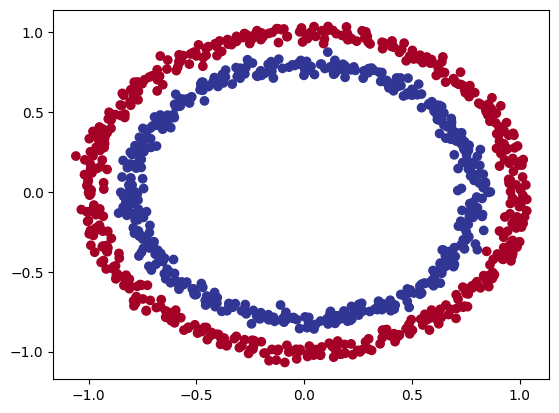

In [145]:
# visualizing the raw data
plt.scatter(
    X[:,0],
    X[:,1],
    c=[*y],
    cmap = plt.colormaps.get_cmap("RdYlBu")
)

In [146]:
# creating a classification model
class circle_classification_Model(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 =  nn.Linear(in_features=5,out_features=1)

  def forward(self,x:torch.Tensor):
    return self.layer_2(self.layer_1(x))


In [147]:
model_0 = circle_classification_Model().to(device)
model_0.state_dict(),model_0

(OrderedDict([('layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188]])),
              ('layer_1.bias',
               tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
              ('layer_2.weight',
               tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
              ('layer_2.bias', tensor([-0.2060]))]),
 circle_classification_Model(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ))

In [148]:
# loss function 
loss_fn = nn.BCEWithLogitsLoss()
# optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),lr = .01)

## Training the model
1. forward pass
2. calculate the loss
3. optimizer zero gradinet
4. loss backward (backpropagation)
5. optimizer step (gradient descent)

### going from raw logits → prediction probabilities → prediction labels
our model outputs are going to be raw **logits**

we can convert these **logits** into **prediction probabilites** by passing them to some kind of activation function (aka the sigmoid activation function for binary classification and softmax for multiclass classification)

then we can convert our models prediction probabilities to **prediction labels** by either rounding them or taking the `torch.argmax()`

in the next 2 lines of code we match the outputs of the sigmoid function so that:
- `Y_predictions_probabilities` >= .5 , `y = 1` (matches the **first** class)
- `Y_predictions_probabilities` < .5 , `y = 0` (matches the **second** class)

In [149]:
### working with logits

#? since we can't predict using logits straghit away, in this block we show the process the model should be doing behind the scene...

# evaluation mode turned on
model_0.eval()
# using env variables of inference mode
with torch.inference_mode():
  # getting first outputs as logits
  y_logits = model_0(X_test).to(device)
  # converting logit to probabilities
  y_probs = torch.sigmoid(y_logits)
  # converting probabilities to final predictions
  y_preds = torch.round(y_probs)

# in total : Outputs -> Logits -> Probabilities -> predictions!
review = torch.hstack((y_logits,y_probs,y_preds))
Cols=[
  "Logits",
  "Probabilities",
  "Predictions"
]

In [150]:
review = torch.hstack((y_logits,y_probs,y_preds))
Cols=[
    "Logits",
    "Probabilities",
    "Predictions"
]
sample = random_sample(review,10,Cols=Cols,df=True)
sample

,Logits,Probabilities,Predictions
0,-0.115093,0.471259,0.0
1,-0.171280,0.457284,0.0
2,-0.113201,0.471730,0.0
3,-0.091667,0.477099,0.0
4,-0.183452,0.454265,0.0
5,-0.103552,0.474135,0.0
6,-0.188192,0.453090,0.0
7,-0.080828,0.479804,0.0
8,-0.174591,0.456463,0.0
9,-0.093571,0.476624,0.0


In [151]:
progress = 0

In [152]:
# training the model 
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100
progress += epochs

for epoch in range(epochs):
  # turn on training mode
  model_0.train()

  # 1. forward pass
  y_logits = model_0(X_train).squeeze()
  y_probs = torch.sigmoid(y_logits)
  y_preds = torch.round(y_probs)


  # 2. calculate the loss
  #? this is the other option for the computation
  #? loss_without_logits = Loss_fn(torch.sigmoid(Y_logits),Y_train) # nn.BCELoss takes probabilities as inputs

  loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss takes logits as inputs
  acc = accuracy_fn(Y_true=y_train.squeeze(),Y_predictions=y_preds.squeeze())

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_0(X_test).squeeze()
    test_probs = torch.sigmoid(test_logits)
    test_preds = torch.round(test_probs)

    # 2. calculate test loss/acc
    test_loss = loss_fn(test_logits,test_preds)
    test_acc =accuracy_fn(Y_true=y_test.squeeze(),Y_predictions=test_preds.squeeze())
  if epoch%10 == 0 :
    print(f'Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f} | Test loss : {test_loss:.5f} | Test acc : {test_acc:.2f}')
print(progress)

Epoch : 0 | Loss : 0.69569 | Acc : 0.50 | Test loss : 0.62505 | Test acc : 0.50
Epoch : 10 | Loss : 0.69544 | Acc : 0.50 | Test loss : 0.62835 | Test acc : 0.50
Epoch : 20 | Loss : 0.69522 | Acc : 0.50 | Test loss : 0.63149 | Test acc : 0.50
Epoch : 30 | Loss : 0.69501 | Acc : 0.50 | Test loss : 0.63449 | Test acc : 0.50
Epoch : 40 | Loss : 0.69483 | Acc : 0.50 | Test loss : 0.63736 | Test acc : 0.50
Epoch : 50 | Loss : 0.69467 | Acc : 0.50 | Test loss : 0.64009 | Test acc : 0.50
Epoch : 60 | Loss : 0.69452 | Acc : 0.50 | Test loss : 0.64270 | Test acc : 0.50
Epoch : 70 | Loss : 0.69438 | Acc : 0.50 | Test loss : 0.64518 | Test acc : 0.50
Epoch : 80 | Loss : 0.69426 | Acc : 0.50 | Test loss : 0.64755 | Test acc : 0.50
Epoch : 90 | Loss : 0.69415 | Acc : 0.50 | Test loss : 0.64981 | Test acc : 0.50
100


In [153]:
review = torch.vstack((test_logits,test_probs,test_preds))
# Cols=[
#     "Logits",
#     "Probabilities",
#     "Predictions"
# ]
# sample = random_sample(review,10,Cols=Cols,df=True)
# sample
review.T.shape
review = review.T
review[:,2].sum()

tensor(0.)

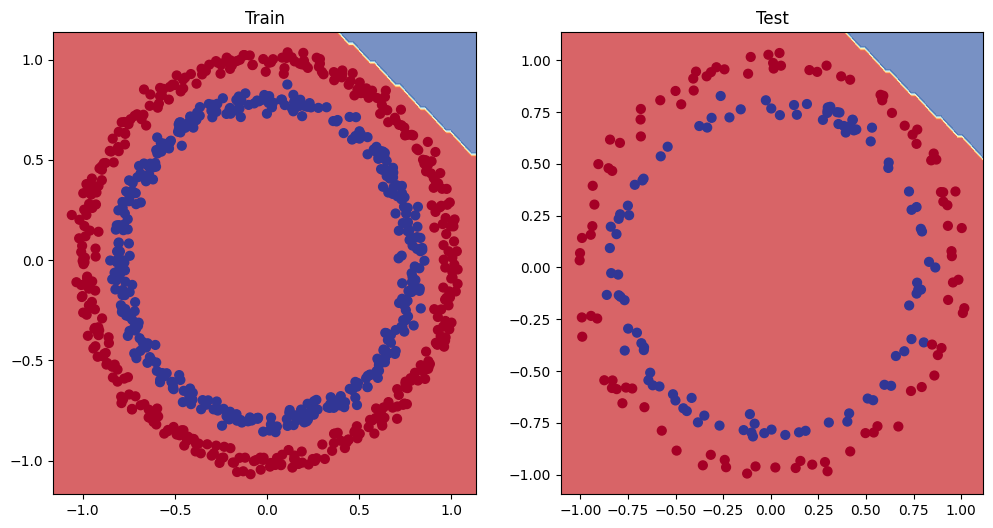

In [154]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


### improving a model 

##### after constructing a model for our problem we might no be satisfied from the results.<br> asuming the data is valid and relavent, we have a few approches that we can take :

* add more layers - give the model more chances to learn about patterns
* add more hidden units - increase amount of weights and biases 
* train for more epochs
* changing the activation function - make better decision for when the neuron is sensitive to change
* change learning rate
* change the loss functions - requires mathematical analysis

these options are all from a model's perspective because they deal directly with the model, rather than the data.
And because these parameters are all values we can change, they are refered to as **hyperparameters**

lets try and improve our model by:
* adding more units : 5 -> 10
* increase the number of layers : 2 -> 3
* increase the number of epochs : 100 -> 1000

In [155]:
for param in model_0.parameters():
    print(f'{param} \n')

Parameter containing:
tensor([[ 0.5407,  0.5869],
        [-0.1665,  0.6493],
        [-0.1551,  0.1426],
        [-0.3438,  0.4154],
        [ 0.6231, -0.5188]], requires_grad=True) 

Parameter containing:
tensor([0.6130, 0.1424, 0.5246, 0.0897, 0.3444], requires_grad=True) 

Parameter containing:
tensor([[-0.0471,  0.3486,  0.0816, -0.2056,  0.1229]], requires_grad=True) 

Parameter containing:
tensor([-0.1769], requires_grad=True) 



In [156]:
# creating a new model based on the previous model but with the desired changes 
class circle_classification_Model_V2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [157]:
model_1 = circle_classification_Model_V2()
model_1

circle_classification_Model_V2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [158]:
# create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# create an optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr= 0.1
)

In [159]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    ###? train
    # 
    model_1.train()

    # 1. forward pass
    train_logits = model_1(X_train).squeeze()
    train_probs = torch.sigmoid(train_logits)
    train_preds = torch.round(train_probs)

    # 2. calc the loss
    loss = loss_fn(train_logits,y_train)
    acc = accuracy_fn(
        Y_true=y_train,
        Y_predictions=train_preds
        )

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards (backpropagation)
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ####? testing
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_1(X_test).squeeze()
        test_probs = torch.sigmoid(test_logits)
        test_preds = torch.round(test_probs)

        # 2. calc the loss
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(Y_true=y_test,Y_predictions=test_preds)
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f} | Test loss : {test_loss:.5f} | Test acc : {test_acc:.2f}')




Epoch : 0 | Loss : 0.69396 | Acc : 0.51 | Test loss : 0.69261 | Test acc : 0.51
Epoch : 100 | Loss : 0.69305 | Acc : 0.50 | Test loss : 0.69379 | Test acc : 0.48
Epoch : 200 | Loss : 0.69299 | Acc : 0.51 | Test loss : 0.69437 | Test acc : 0.46
Epoch : 300 | Loss : 0.69298 | Acc : 0.52 | Test loss : 0.69458 | Test acc : 0.45
Epoch : 400 | Loss : 0.69298 | Acc : 0.51 | Test loss : 0.69465 | Test acc : 0.46
Epoch : 500 | Loss : 0.69298 | Acc : 0.51 | Test loss : 0.69467 | Test acc : 0.46
Epoch : 600 | Loss : 0.69298 | Acc : 0.51 | Test loss : 0.69468 | Test acc : 0.46
Epoch : 700 | Loss : 0.69298 | Acc : 0.51 | Test loss : 0.69468 | Test acc : 0.46
Epoch : 800 | Loss : 0.69298 | Acc : 0.51 | Test loss : 0.69468 | Test acc : 0.46
Epoch : 900 | Loss : 0.69298 | Acc : 0.51 | Test loss : 0.69468 | Test acc : 0.46


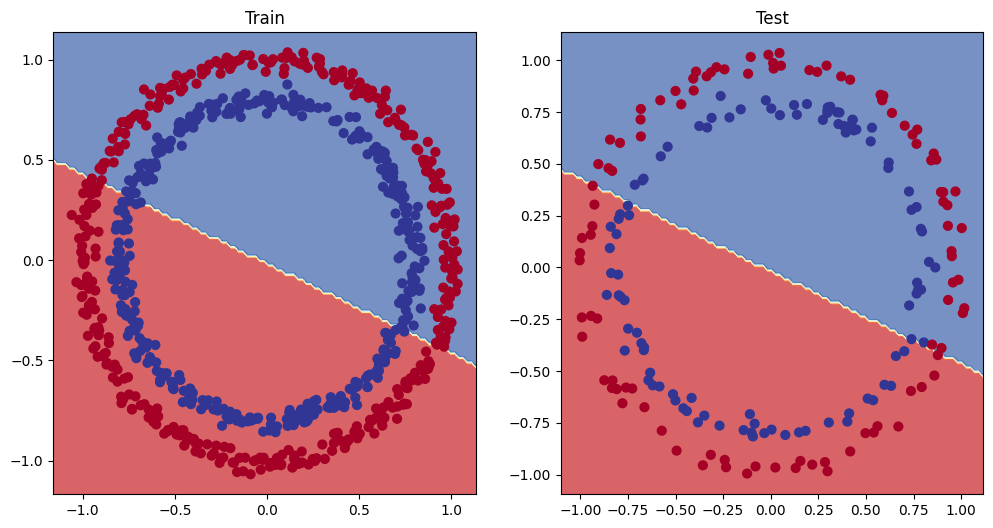

In [160]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

##### whats going on?

we notice that the predictions of our model are still not accurate enough, the model almost has the same "guessing" predictions.<br>
the problem is that we create a linear model for a non linear problem...

therefore, we must draw non-linear patterns from our data with our, so far, linear model

In [161]:
# creating and spliting the data in ratio 80% | 20%
X,y = make_circles(1000,noise = .03,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# = train_test_split(X,test_size=0.2,random_state=42)

# converting the data into torch.tensor
X_train = torch.tensor(X_train,dtype = torch.float).to(device)
X_test = torch.tensor(X_test,dtype = torch.float).to(device)
y_train = torch.tensor(y_train,dtype = torch.float).to(device)
y_test = torch.tensor(y_test,dtype = torch.float).to(device)
# X_train,X_test,y_train,y_test
# len(X_train),len(X_test),len(y_train),len(y_test)
X_train[:10],X_test[:10],y_train[:10],y_test[:10]


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994],
         [-0.8837, -0.4678],
         [-0.3836,  0.6987],
         [ 0.6047,  0.5163],
         [-0.5869,  0.7804],
         [ 0.8833, -0.5178]]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [162]:
# creating a new model based on the previous model but with the desired changes 
class circle_classification_Model_V3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.RelU = nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.RelU(self.layer_2(self.RelU(self.layer_1(x)))))

In [163]:
model_2 = circle_classification_Model_V3().to(device)
model_2 = nn.Sequential(
    nn.Linear(in_features=2,out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10,out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10,out_features=1)
)
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]])),
             ('0.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642])),
             ('2.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  0.2663,  0.1232, -0.0157, -0.1907, -0.1935, -0.2833, -0.1

In [166]:
training_loop(
    model_2,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.1),
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
    epochs=1000
)

# loss_fn=nn.BCEWithLogitsLoss()
# optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.1)
# # training the model 
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# epochs = 1000
# _step = epochs//10

# for epoch in range(epochs):
#     # turn on training mode
#     model_2.train()

#     # 1. forward pass
#     y_logits = model_2(X_train).squeeze()
#     # y_probs = torch.sigmoid(y_logits)
#     y_preds = torch.round(torch.sigmoid(y_probs))


#     # 2. calculate the loss
#     #? this is the other option for the computation
#     #? loss_without_logits = Loss_fn(torch.sigmoid(Y_logits),Y_train) # nn.BCELoss takes probabilities as inputs

#     loss = loss_fn(y_logits,y_train) # nn.BCEWithLogitsLoss takes logits as inputs
#     acc = accuracy_fn(Y_true=y_train.squeeze(),Y_predictions=y_preds.squeeze())

#     # 3. optimizer zero grad
#     optimizer.zero_grad()

#     # 4. Loss backward (backpropagation)
#     loss.backward()

#     # 5. optimizer step (gradient descent)
#     optimizer.step()

#     ### Testing
#     model_2.eval()
#     with torch.inference_mode():
#         # 1. forward pass
#         test_logits = model_2(X_test).squeeze()
#         test_probs = torch.sigmoid(test_logits)
#         test_preds = torch.round(test_probs)

#         # 2. calculate test loss/acc
#         test_loss = loss_fn(test_logits,test_preds)
#         test_acc =accuracy_fn(Y_true=y_test.squeeze(),Y_predictions=test_preds.squeeze())
#     if epoch% _step == 0 :
#         print(f'Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f} | Test loss : {test_loss:.5f} | Test acc : {test_acc:.2f}')


Epoch : 0 | Loss : 0.67298% | Acc : 59.62% | Test loss : 0.67067% | Test acc : 59.50%
Epoch : 100 | Loss : 0.66661% | Acc : 61.12% | Test loss : 0.66544% | Test acc : 62.00%
Epoch : 200 | Loss : 0.65590% | Acc : 64.25% | Test loss : 0.65707% | Test acc : 65.00%
Epoch : 300 | Loss : 0.63900% | Acc : 67.38% | Test loss : 0.64342% | Test acc : 69.00%
Epoch : 400 | Loss : 0.60738% | Acc : 74.00% | Test loss : 0.61813% | Test acc : 74.50%
Epoch : 500 | Loss : 0.54766% | Acc : 90.00% | Test loss : 0.56642% | Test acc : 85.00%
Epoch : 600 | Loss : 0.44892% | Acc : 96.75% | Test loss : 0.47627% | Test acc : 94.50%
Epoch : 700 | Loss : 0.32490% | Acc : 99.00% | Test loss : 0.35720% | Test acc : 98.50%
Epoch : 800 | Loss : 0.21186% | Acc : 99.88% | Test loss : 0.24664% | Test acc : 99.00%
Epoch : 900 | Loss : 0.15692% | Acc : 99.75% | Test loss : 0.19321% | Test acc : 99.00%
1000


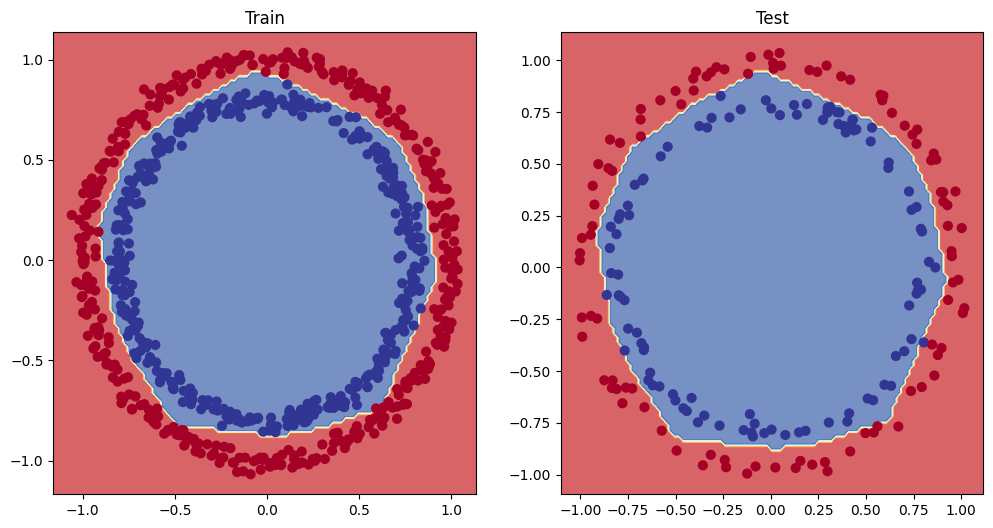

In [167]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)